# Config

In [1]:
plant = "G.max"
plant_name = "Glycine max"
input_genome_name = "GCF_000004515.6_Glycine_max_v4.0_genomic.fna"

experiment_dir = "./Experiment"
experiment = f"{plant}/negative"

input_genome_path = f'{experiment_dir}/{plant}/{input_genome_name}'

temp_path = f"{experiment_dir}/{experiment}/Temp"
result_path = f"{experiment_dir}/{experiment}/Result"

temp_path_f = temp_path.replace(" ", "\ ")
result_path_f = result_path.replace(" ", "\ ")

In [2]:
import os
if(not os.path.exists(f'{experiment_dir}/{experiment}')):
    os.mkdir(f'{experiment_dir}/{experiment}')

# Common

In [3]:
#!pip install tqdm

In [4]:
import json
import time
from subprocess import Popen, PIPE, STDOUT
import math
import numpy as np
import pandas as pd
import hashlib
import requests
import os, sys, subprocess
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm
tqdm.pandas()
import multiprocessing as mp
import shutil
import urllib.parse
import glob
import os
import sys
import networkx
from networkx.algorithms.clique import find_cliques as maximal_cliques
from ast import literal_eval
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
sys.path.append("./src/")
from ct_analizer import get_row
from filter1 import filter1_run
from filter2 import filter2

In [5]:
if(not os.path.exists(temp_path)):
    os.mkdir(temp_path)
    
if(not os.path.exists(result_path)):
    os.mkdir(result_path)

In [6]:
current_path = os.getcwd()

In [7]:
def bracket_row(row):    
    s = row['data']
    index = min(s.find('.'), s.find('('))
    data = row['data']
    row['data'] = data[0:index]
    row['bracket'] = data[index:]
    return row

In [8]:
def adjust(text,n=7):
    text = str(text)    
    return " " * (n - len(text)) + text

In [9]:
def bracket_to_ct(tag, data, bracket, deltaG, negative_deltaG=True):    
    deltaG = deltaG.replace('(','').replace(')','')
    deltaG = float(deltaG)
    if(deltaG > 0 and negative_deltaG ): # negetive?!
        deltaG = -1 * deltaG
    stack = []
    index = np.zeros((len(bracket)), dtype = int)
    values = np.zeros((len(bracket)), dtype = int)
    for i in range(len(bracket)):
        index[i] = i + 1
        if(bracket[i] == '.'):
            values[i] = 0
        elif(bracket[i] == '('):
            stack.append(i)
        elif(bracket[i] == ')'):
            if(len(stack) == 0 ):
                print('structure error!')
            values[stack[-1]] = i + 1
            values[i]  = stack[-1] + 1
            stack.pop()
        else:
            print('structure error!')
    if(len(stack) != 0 ):
        print('structure error!')
    # body    
    ct = f"{adjust(len(data),6)} dG ={adjust(deltaG,10)} {tag}\n"   
    for i in range(len(bracket)):
        ct += f"{adjust(index[i],6)} {data[i]} {adjust(i,6)} {adjust((i+2)%(len(data)+1),6)} {adjust(values[i],6)} {adjust(index[i],7)}\n"
    return ct

In [10]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [11]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [12]:
def reformat(path):
    return path.replace('(','_').replace(')','_').replace('.','').replace(':','_')

In [13]:
def reformatCT(path):
    with open(path, 'r') as file:
        text = file.read()
    text = [l for l in text.split('\n') if len(l) > 0 ] # remove blank lines
    text = '\n'.join(text)
    text = text.replace("\t"," ")
    while("  " in text):
        text = text.replace("  ", " ")
    lines = [l for l in text.split('\n')]
    for i in range(len(lines)):
        if(lines[i][0] == " "):
            lines[i] = lines[i][1:]
        if(lines[i][-1] == " "):
            lines[i] = lines[i][:-1]
    text = '\n'.join(lines)
    return text

In [14]:
def get_ct_data(ct):
    ct = "\n".join(ct.split('\n')[1:])
    df = pd.read_csv(StringIO(ct), sep=" ", header=None)               
    nucleotide = df.iloc[:,1]
    index = df.iloc[:,5]
    values = df.iloc[:,4]
    return [nucleotide, index, values]

In [15]:
def ct2dot_bracket(path):
    [nucleotide, index, values] = get_ct_data(reformatCT(path))
    text = ''.join(nucleotide) + "\n"
    watch = []
    for i, v in zip(index,values):
        if(v == 0):
            text += '.'
        else:
            if( v not in watch):
                text += '('
                watch.append(i)
            if( v in watch):
                text += ')'
    return text

In [16]:
def is_nested(index, values):
    max_value = max(index) + 10 # inf
    for i, v in zip(index, values):
        if(v < max_value and v != 0):
            max_value  = v
        if(i >= max_value):
            max_value = max(index) + 10 # inf
        if(v > max_value):
            return False               
    return True

# Download data from Mirbase

In [17]:
directory = './miRBase'
base = "https://www.mirbase.org/ftp/CURRENT"        

In [18]:
mature = fasta_to_df(f'{directory}/mature.fa')
mature_high_conf = fasta_to_df(f'{directory}/mature_high_conf.fa')
mature['trim tag'] = mature['tag'].apply(lambda line: ' '.join(line.split(' ')[:2]))
mature['confidence'] = mature['trim tag'].isin(mature_high_conf['tag'])

In [19]:
mature['organism'] = mature['tag'].apply(lambda x: x[:3])
print(mature.shape)
mature.head(2)

(48885, 5)


,tag,data,trim tag,confidence,organism
0,cel-let-7-5p MIMAT0000001 Caenorhabditis elega...,UGAGGUAGUAGGUUGUAUAGUU,cel-let-7-5p MIMAT0000001,True,cel
1,cel-let-7-3p MIMAT0015091 Caenorhabditis elega...,CUAUGCAAUUUUCUACCUUACC,cel-let-7-3p MIMAT0015091,True,cel


In [20]:
organism = pd.read_csv(f'./{directory}/organisms.txt',sep='\t')
organism.columns = [c.replace('#','') for c in organism.columns] # remove sharp from columns
print(organism.shape)
organism.head(2)

(285, 5)


,organism,division,name,tree,NCBI-taxid
0,aqu,AQU,Amphimedon queenslandica,Metazoa;Porifera;,400682
1,nve,NVE,Nematostella vectensis,Metazoa;Cnidaria;,45351


In [21]:
items = list(organism['tree'].unique())
items.sort(key=len)
items

['Viruses;',
 'Mycetozoa;',
 'Alveolata;',
 'Metazoa;Porifera;',
 'Metazoa;Cnidaria;',
 'Viridiplantae;Chlorophyta;',
 'Viridiplantae;Embryophyta;',
 'Viridiplantae;Coniferophyta;',
 'Viridiplantae;Magnoliophyta;',
 'Metazoa;Bilateria;Deuterostoma;',
 'Chromalveolata;Heterokontophyta;',
 'Metazoa;Bilateria;Ecdysozoa;Nematoda;',
 'Metazoa;Bilateria;Lophotrochozoa;Annelida;',
 'Metazoa;Bilateria;Lophotrochozoa;Nemertea;',
 'Metazoa;Bilateria;Lophotrochozoa;Mollusca;',
 'Viridiplantae;Magnoliophyta;monocotyledons;',
 'Metazoa;Bilateria;Deuterostoma;Hemichordata;',
 'Metazoa;Bilateria;Deuterostoma;Echinodermata;',
 'Metazoa;Bilateria;Lophotrochozoa;Brachiopoda;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Hexapoda;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Crustacea;',
 'Metazoa;Bilateria;Lophotrochozoa;Platyhelminthes;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Chelicerata;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Mandibulata;',
 'Viridiplantae;Magnoliophyta;eudicotyledons;Poaceae;',
 'M

In [22]:
selectedTree = organism[organism['tree'].apply(lambda x: "Viridiplantae;" in x)]
print(selectedTree.shape)
selectedTree.head(5)

(86, 5)


,organism,division,name,tree,NCBI-taxid
66,cre,CRE,Chlamydomonas reinhardtii,Viridiplantae;Chlorophyta;,3055
67,pta,PTA,Pinus taeda,Viridiplantae;Coniferophyta;,3352
68,ppt,PPT,Physcomitrella patens,Viridiplantae;Embryophyta;,3218
69,smo,SMO,Selaginella moellendorffii,Viridiplantae;Embryophyta;,88036
70,ath,ATH,Arabidopsis thaliana,Viridiplantae;Magnoliophyta;eudicotyledons;Bra...,3702


In [23]:
for i in selectedTree['name']:
    print(i)

Chlamydomonas reinhardtii
Pinus taeda
Physcomitrella patens
Selaginella moellendorffii
Arabidopsis thaliana
Brassica napus
Brassica oleracea
Brassica rapa
Carica papaya
Glycine max
Lotus japonicus
Medicago truncatula
Vigna unguiculata
Gossypium herbaceum
Gossypium hirsutum
Gossypium raimondii
Populus trichocarpa
Solanum lycopersicum
Vitis vinifera
Oryza sativa
Sorghum bicolor
Saccharum officinarum
Triticum aestivum
Zea mays
Phaseolus vulgaris
Malus domestica
Brachypodium distachyon
Aquilegia caerulea
Populus euphratica
Citrus sinensis
Citrus clementina
Citrus reticulata
Citrus trifoliata
Ricinus communis
Gossypium arboreum
Arabidopsis lyrata
Arachis hypogaea
Glycine soja
Picea abies
Triticum turgidum
Aegilops tauschii
Hordeum vulgare
Papaver somniferum
Festuca arundinacea
Bruguiera gymnorhiza
Bruguiera cylindrica
Cunninghamia lanceolata
Theobroma cacao
Rehmannia glutinosa
Cucumis melo
Saccharum sp.
Acacia mangium
Acacia auriculiformis
Salvia sclarea
Digitalis purpurea
Nicotiana tabacum

In [24]:
selectedTree = selectedTree[selectedTree['name'] == plant_name]

In [25]:
selected = mature[mature['organism'].isin(selectedTree['organism'])]
print(selected.shape)
selected.head(1)

(756, 5)


,tag,data,trim tag,confidence,organism
2556,gma-miR156d MIMAT0001672 Glycine max miR156d,UUGACAGAAGAUAGAGAGCAC,gma-miR156d MIMAT0001672,False,gma


In [26]:
df_to_fasta(selected,f'{temp_path}/mature_microRNA_queries.fasta')

# Remove redundant

## cdhit-est

In [27]:
!./software/cdhit/cd-hit-est -i ./{temp_path_f}/mature_microRNA_queries.fasta  -o ./{temp_path_f}/NR_mature_microRNA_queries.fasta \
    -c 1 -r 0 -G 1 -g 1 -b 30 -l 10 -aL 0 -AL 99999999 -aS 0 \
    -AS 99999999 -s 0 -S 0

Program: CD-HIT, V4.8.1 (+OpenMP), Oct 23 2021, 21:45:39
Command: ./software/cdhit/cd-hit-est -i
         ././Experiment/G.max/negative/Temp/mature_microRNA_queries.fasta
         -o
         ././Experiment/G.max/negative/Temp/NR_mature_microRNA_queries.fasta
         -c 1 -r 0 -G 1 -g 1 -b 30 -l 10 -aL 0 -AL 99999999 -aS
         0 -AS 99999999 -s 0 -S 0

Started: Thu Sep 15 14:52:18 2022
                            Output                              
----------------------------------------------------------------
total seq: 756
longest and shortest : 25 and 18
Total letters: 16449
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 12M = 12M
Table           : 1 X 16M = 16M
Miscellaneous   : 0M
Total           : 28M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 96378876

comparing sequences from          0  to        756

      756  finished        569 

## reformat

In [28]:
with open(f'./{temp_path}/NR_mature_microRNA_queries.fasta.clstr','r') as file:
    text = file.read()
lines = [line for line in text.split('\n') if len(line) > 0]
cluster = []
seqid = []
last_cluster = ""
for l in lines:
    if(l[0]=='>'):        
        last_cluster = l.replace('>Cluster ',"C")
    else:        
        cluster.append(last_cluster)
        seqid.append(l.split(', >')[1].split('...')[0])                
seq2cluster = pd.DataFrame({'seqid': seqid,'cluster': cluster})
print(seq2cluster.shape)
seq2cluster.head(2)    

(756, 2)


,seqid,cluster
0,gma-miR396f,C0
1,gma-miR10423,C1


In [29]:
df = fasta_to_df(f"./{temp_path}/mature_microRNA_queries.fasta")
df['accession'] = df['tag'].apply(lambda x : x.split(' ')[0])
seq2cluster = pd.merge(df,seq2cluster,how="inner",left_on='accession',right_on="seqid")
seq2cluster = pd.merge(seq2cluster, mature,how="inner",left_on='tag',right_on="tag")[['cluster','seqid','tag', 'confidence']]
print(seq2cluster.shape)
display(seq2cluster.head(2))
seq2cluster.to_csv(f'./{temp_path}/seq2cluster.csv',index=False)

(756, 4)


,cluster,seqid,tag,confidence
0,C283,gma-miR156d,gma-miR156d MIMAT0001672 Glycine max miR156d,False
1,C284,gma-miR156e,gma-miR156e MIMAT0001673 Glycine max miR156e,False


In [30]:
# todo: sorted first by cluster then by seqid
seq2cluster.sort_values("cluster").head(2)

,cluster,seqid,tag,confidence
311,C0,gma-miR396f,gma-miR396f MIMAT0021069 Glycine max miR396f,False
696,C1,gma-miR10423,gma-miR10423 MIMAT0041670 Glycine max miR10423,False


In [31]:
df = fasta_to_df(f"./{temp_path}/NR_mature_microRNA_queries.fasta")
df['tag'] = df['tag'].apply(lambda x : x.split(' ')[0])
df = pd.merge(df,seq2cluster,how="inner",left_on='tag',right_on="seqid")[['cluster','data']]

lines = []
df.apply(lambda row: lines.append(f">{row['cluster']}\n{row['data']}\n"),axis=1)
print(df.shape)
with open(f'./{temp_path}/BLASTn_queries.fasta','w') as file:
    file.write(''.join(lines))

(569, 2)


# BlastN

!sudo apt-get install ncbi-blast+


In [32]:
!makeblastdb -in {input_genome_path} -dbtype nucl -out ./{temp_path_f}/blastn_database



Building a new DB, current time: 09/15/2022 14:52:23
New DB name:   /home/jupyter/plant_microRNA_prediction/Experiment/G.max/negative/Temp/blastn_database
New DB title:  ./Experiment/G.max/GCF_000004515.6_Glycine_max_v4.0_genomic.fna
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 284 sequences in 22.9474 seconds.


In [33]:
header = 'qseqid sseqid qstart qend sstart send qseq sseq evalue bitscore score length pident nident mismatch positive gapopen gaps ppos frames qframe sframe sstrand qcovs qcovhsp qlen slen'

In [34]:
!blastn -query ./{temp_path}/BLASTn_queries.fasta \
        -task blastn-short \
        -out ./{temp_path}/BLASTn_result \
        -num_threads {mp.cpu_count()} \
        -db ./{temp_path}/blastn_database \
        -word_size 7 \
        -penalty -3 \
        -reward 1 \
        -gapopen 5 \
        -gapextend 2 \
        -evalue 10 \
        -outfmt '6 qseqid sseqid qstart qend sstart send qseq sseq evalue bitscore score length pident nident mismatch positive gapopen gaps ppos frames qframe sframe sstrand qcovs qcovhsp qlen slen'       

In [35]:
df_blastn = pd.read_csv(f'./{temp_path}/BLASTn_result', sep='\t',header=None)
df_blastn.columns = header.replace("  "," ").split(" ")
print(df_blastn.shape)
df_blastn.head(2)

(90130, 27)


,qseqid,sseqid,qstart,qend,sstart,send,qseq,sseq,evalue,bitscore,...,gaps,ppos,frames,qframe,sframe,sstrand,qcovs,qcovhsp,qlen,slen
0,C283,NC_038255.2,1,21,8862226,8862246,TTGACAGAAGATAGAGAGCAC,TTGACAGAAGATAGAGAGCAC,0.001,42.1,...,0,100.0,1/1,1,1,plus,100,100,21,51272880
1,C283,NC_038255.2,1,21,8862309,8862289,TTGACAGAAGATAGAGAGCAC,TTGACAGAAGATAGAGAGCAC,0.001,42.1,...,0,100.0,1/-1,1,-1,minus,100,100,21,51272880


In [36]:
threshold_from = 5
threshold_to = 6
df_blastn['Nonconformity'] = df_blastn['qlen'] - (abs(df_blastn['qend'] - df_blastn['qstart']) + 1) + df_blastn['gaps'] + df_blastn['mismatch']
df_blastn = df_blastn[df_blastn['Nonconformity'] >= threshold_from]
df_blastn = df_blastn[df_blastn['Nonconformity'] <= threshold_to]
print(df_blastn.shape)
df_blastn.head(2)

(26528, 28)


,qseqid,sseqid,qstart,qend,sstart,send,qseq,sseq,evalue,bitscore,...,ppos,frames,qframe,sframe,sstrand,qcovs,qcovhsp,qlen,slen,Nonconformity
10,C283,NC_038245.2,6,20,17243057,17243043,AGAAGATAGAGAGCA,AGAAGATAGAGAGCA,3.9,30.2,...,100.0,1/-1,1,-1,minus,100,71,21,50572668,6
11,C283,NC_038245.2,5,19,19626212,19626198,CAGAAGATAGAGAGC,CAGAAGATAGAGAGC,3.9,30.2,...,100.0,1/-1,1,-1,minus,100,71,21,50572668,6


In [37]:
# alignment length adjustment
def blastn_adjust(row):
    if(row['sstrand'] == "plus"):        
        row['sstart'] = max(1, row['sstart'] - (row['qstart'] - 1))
        row['send'] = min(row['slen'], row['send'] + (row['qlen'] - row['qend']))
    if(row['sstrand'] == "minus"):        
        row['send'] = max(1, row['send'] - (row['qstart'] - 1 ))
        row['sstart'] = min(row['slen'], row['sstart'] + (row['qlen'] - row['qend'] ))
    return row
    
df_blastn = df_blastn.apply(lambda row: blastn_adjust(row), axis=1)

In [38]:
# remore redundancy and hold best one base of Nonconformity value
df_blastn = df_blastn.sort_values(["Nonconformity", "evalue"], ascending = (True, True))
df_blastn = df_blastn.drop_duplicates(subset=['sseqid','sstart', 'qseqid', 'send','sstrand'], keep='first')
df_blastn.to_csv(f'./{temp_path}/filtered_out_blastn.csv')
print(df_blastn.shape)

(26528, 28)


# Result of the blastn to bed file

In [39]:
df = df_blastn[['qseqid', 'sseqid', 'sstart', 'send', 'sstrand','slen']]
df['ones'] = 1

<ipython-input-39-eba70d589136>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


In [40]:
def switch(row):
    if(row['sstart'] > row['send']):        
        temp = row['sstart']
        row['sstart'] = row['send']
        row['send'] = temp
    return row
df = df.apply(lambda row: switch(row), axis=1)

In [41]:
def convert(inp):
    if(inp == "plus"):
        return "forward"
    if(inp == "minus"):
        return "reverse"
    raise Exception('Error, sstrand contains illegal word! only "plus" and "minus" are allowed')
df['strand'] = df['sstrand'].apply(lambda x: convert(x))

In [42]:
def convert2sign(inp):
    if(inp == "plus"):
        return "+"
    if(inp == "minus"):
        return "-"
    raise Exception('Error, sstrand contains illegal word! only "plus" and "minus" are allowed')
df['sign'] = df['sstrand'].apply(lambda x: convert2sign(x))

In [43]:
df['hit_length'] = df.apply(lambda row: abs(row['send'] - row['sstart']) + 1 ,axis=1)

## convert sstart and send from location to index (range)

In [44]:
df['sstart'] = df['sstart'].apply(lambda x: x - 1)

In [45]:
temp = fasta_to_df(temp_path.replace('negative', 'positive') + "/" + "extended_modified_non_coding.txt")
lengths = []
for indx, row in temp.iterrows():
    tag = row['tag']
    seq = row['data']
    [start, end] = tag.split('|')[-1].split('-')
    down = int(start) - 1
    up = len(seq) - int(end)
    lengths.append([down, up])        
    lengths.append([up, down])        
lengths = pd.DataFrame(lengths, columns=["up", "down"])
idx = np.random.choice(lengths.index, df.shape[0])
lengths = lengths.iloc[idx]
lengths = lengths.reset_index(drop=True)
df['down'] = lengths['down'].values
df['up'] = lengths['up'].values
df['downstream_flanking'] = df.apply(lambda row:  min(row['down'], row['sstart']), axis=1)
df['upstream_flanking'] = df.apply(lambda row:  row['up'] if (row['send']+row['up'] ) <= row['slen'] else row['slen'] - row['send'],axis=1)


In [46]:
df['hit_start'] = df.apply(lambda row: row['downstream_flanking'] if row['sign'] == "+" else row['upstream_flanking'],axis=1)

In [47]:
df['hit_end'] = df.apply(lambda row: row['downstream_flanking'] + row['hit_length'] if row['sign'] == "+" else row['upstream_flanking'] + row['hit_length'],axis=1)

In [48]:
df['sstart'] = df.apply(lambda row: max(row['sstart'] - row['down'], 0),axis=1)
df['send'] = df.apply(lambda row: min(row['send'] + row['up'] , row['slen']),axis=1)

In [49]:
df['tag'] = df.apply(lambda row: f">{row['sseqid']}:{row['sstart']}-{row['send']}({row['sign']})",axis=1)
df['reformated_tag'] = df['tag'].apply(lambda t: reformat(t))
df[['tag', 'reformated_tag', 'hit_start', 'hit_end']].to_csv(f'./{temp_path}/hit_index_info.csv')#, index=False)

In [50]:
df['location_tag'] = df.apply(lambda row: f">{row['sseqid']}|{row['sign']}|{row['sstart'] + 1}-{row['send']}|{row['hit_start']+1}-{row['hit_end']}",axis=1)
df[['location_tag','qseqid']].to_csv(f'./{temp_path}/pipe_seprated_location_list.csv',index=False,sep='\t')

In [51]:
df[['sseqid','sstart','send','strand','ones', 'sign']].to_csv(f'./{temp_path}/extension_index.bed', 
        index=False, header=False, sep="\t")

# Extention


In [52]:
# !sudo apt-get install bedtools

In [53]:
!bedtools getfasta -fi {input_genome_path} -fo ./{temp_path}/extended_original.txt -s -bed ./{temp_path}/extension_index.bed
!rm input_genome.fna.fai

rm: cannot remove 'input_genome.fna.fai': No such file or directory


In [54]:
# todo: remove duplicated
'''
df = fasta_to_df("./Temp/extended.txt")
df = df.drop_duplicates(subset=['tag'], keep='first')
df_to_fasta(df,"./Temp/extended.txt")
len(df['tag'].unique())
''';

# Convert hit region to upper case and other region to lower case

In [55]:
ext = fasta_to_df(f'./{temp_path}/extended_original.txt')
info = pd.read_csv(f'./{temp_path}/hit_index_info.csv')
info['tag'] = info['tag'].apply(lambda x: x[1:])
print(info.shape)
info.head(2)

(26528, 5)


,Unnamed: 0,tag,reformated_tag,hit_start,hit_end
0,77748,NC_038254.2:47014762-47015031(-),>NC_0382542_47014762-47015031_-_,30,55
1,3488,NC_038251.2:44998352-44998525(-),>NC_0382512_44998352-44998525_-_,30,54


In [56]:
ext = ext.sort_values(by=['tag']).reset_index()
ext['help_tag'] = ext.apply(lambda r: r['tag'] + str(r.name),axis=1)
del ext['tag']

info = info.sort_values(by=['tag']).reset_index()
info['help_tag'] = info.apply(lambda row: row['tag']+ str(row.name),axis=1)
def redefined_tag(row):
    tag = row['tag']
    [sstart, send] = tag.split(':')[-1].split('(')[0].split('-')
    sstart = int(sstart) + 1
    sign = tag.split('(')[-1].split(')')[0]    
    return f"{tag.split(':')[0]}|{sign}|{sstart}-{send}|{row['hit_start']+1}-{row['hit_end']}"
info['tag'] = info.apply(lambda row: redefined_tag(row),axis=1)
ext = pd.merge(ext,info,how='inner', on='help_tag')

def emphasis_hit(row):
    seq = list(row['data'].lower())            
    s = row['hit_start']
    e = row['hit_end']
    seq[s:e] = list(''.join(seq[s:e]).upper())    
    return ''.join(seq)
    
ext['data'] = ext.apply(lambda row: emphasis_hit(row),axis=1)
ext = ext.drop_duplicates(subset=['data'], keep='first')
df_to_fasta(ext[['tag','data']],f"./{temp_path}/extended_modified.txt")

# Protein coding elimination [Diamond]

In [57]:
#!./diamond makedb --in ./NR/nr -d ./Temp/diamond_output

In [58]:
#!./diamond blastx -d ./Temp/diamond_output.dmnd \
#                  -q ./Temp/extended_modified.txt \
#                  -o ./Temp/diamond_matches.tsv \
#                  -p 22

In [59]:
dmn = pd.read_csv(f"./{temp_path}/diamond_matches.tsv", sep='\t', header=None)
dmn.columns = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'.split(' ')
coding_seq = dmn['qseqid'].unique()

In [60]:
def clear(inp):
    if(inp[:9] == "reverse::"):
        return inp[9:]
    if(inp[:9] == "forward::"):
        return inp[9:]
    return inp
coding_seq = pd.Series(coding_seq).apply(lambda x : clear(x))

ext = fasta_to_df(f'./{temp_path}/extended_modified.txt')
print(f'total:      {ext.shape[0]}')
non_coding = ext[~ext['tag'].isin(coding_seq)]
print(f'non_coding: {non_coding.shape[0]}')
df_to_fasta(non_coding,f'./{temp_path}/extended_modified_non_coding.txt')
coding = ext[ext['tag'].isin(coding_seq)]
print(f'coding:     {coding.shape[0]}')
df_to_fasta(coding,f'./{temp_path}/extended_modified_coding.txt')

total:      26521
non_coding: 20834
coding:     5687


# RNA 2d prediction

## Mfold

In [61]:
counter = 0
base = f"{result_path}/secondary_structure/mfold/"
!rm -r {base}
!mkdir -p {base}
df = fasta_to_df(f'./{temp_path}/extended_modified_coding.txt')

for index, row in df.iterrows():    
    tag = reformat(row['tag'])
    if(not os.path.exists(base + tag)):
        os.makedirs(base + tag)            
    with open(base + f"{tag}/SEQ.FASTA",'w') as file:
        file.write(f">{row['tag']}\n{row['data']}")
    counter += 1    
    #if(counter >= 100):
      #  break

rm: cannot remove './Experiment/G.max/negative/Result/secondary_structure/mfold/': No such file or directory


In [62]:
%%capture
remove_lock = False
def run_mfold(tag):
    tag = reformat(tag)
    %cd {base + tag}
    !mfold  SEQ="SEQ.FASTA" T=22   
    if(not remove_lock):
        !find . -name "SEQ*" -not -name "*.ct" -not -name "*.pdf" -not -name "*SEQ.FASTA" -not -type d -delete
    %cd {current_path}

if __name__ == '__main__':        
    pool = mp.Pool(mp.cpu_count() - 5)      
    pool.map(run_mfold, df['tag'])  

In [63]:
print("done")

done


## Mxfold2

In [ ]:
#!wget https://github.com/keio-bioinformatics/mxfold2/releases/download/v0.1.1/mxfold2-0.1.1.tar.gz
#!pip3 install mxfold2-0.1.1.tar.gz
#!rm mxfold2-0.1.1.tar.gz

In [ ]:
!mxfold2 predict ./extended.txt > Result/secondary_structure/mxfold2_result.txt

In [ ]:
df = fasta_to_df('./Result/secondary_structure/mxfold2_result.txt')
df = df.apply(lambda row: bracket_row(row) , axis=1)
df.head(2)

In [ ]:
base = "./Result/secondary_structure/mxfold2/"
!rm -r {base}
!mkdir -p {base}
for index, row in df.iterrows():    
    if(not os.path.exists(base + reformat(row['tag']))):
        os.makedirs(base + reformat(row['tag']))        
    tag = reformat(row['tag'])
    with open(base + f"{tag}/{tag}.ct",'w') as file:
        bracket = row['bracket'].split(' ')[0]
        deltaG = row['bracket'].split(' ')[1]
        ct = bracket_to_ct(row['tag'], row['data'], bracket, deltaG)
        file.write(ct)    

## Vienna package

In [ ]:
#!wget https://www.tbi.univie.ac.at/RNA/download/ubuntu/ubuntu_20_04/viennarna_2.4.18-1_amd64.deb -O viennarna.deb
#!sudo dpkg -i ./viennarna.deb
#!sudo apt-get -f install
#!rm viennarna.deb

In [96]:
base = f"{result_path}/secondary_structure/viennarna/"
!rm -r {base}
!rm {result_path}/secondary_structure/viennarna_result.txt
!mkdir -p {base}

rm: cannot remove 'Experiment/A.thaliana/Result/secondary_structure/viennarna/': No such file or directory
rm: cannot remove 'Experiment/A.thaliana/Result/secondary_structure/viennarna_result.txt': No such file or directory


In [102]:
#%cd {base}
!RNAfold --jobs=0 --infile {current_path}/{temp_path}/extended_modified.txt  --noPS -T 22 > {current_path}/{base}/viennarna_result.txt
#%cd {current_path}

In [107]:
df = fasta_to_df(f'{result_path}/secondary_structure/viennarna/viennarna_result.txt')
df = df.apply(lambda row: bracket_row(row) , axis=1)
print(df.shape)
df.head(2)

(17793, 3)


,tag,data,bracket
0,NC_000932.1|+|101567-101986|201-220,aaucccagggcucaacccuggacaggcgguggaaacuaccaagcuu...,.(((((((((.....)))))).((((((((((...)))))..))))...
1,NC_000932.1|+|105092-105512|201-221,aaucccgugugaaucagcaaggaccaccuugcaaggcuaaauacuc...,.....(((((......((((((....))))))....(((..(((((...


In [108]:
for index, row in df.iterrows():    
    tag = reformat(row['tag'])
    if(not os.path.exists(base + tag)):
        os.makedirs(base + tag)      
    with open(base + f"{tag}/{tag}.ct",'w') as file:
        bracket = row['bracket'].split(' ')[0]
        deltaG = row['bracket'].split(' ')[1]
        ct = bracket_to_ct(row['tag'], row['data'], bracket, deltaG, False)
        file.write(ct)    

In [109]:
import glob
for file in glob.glob(f"{base}*.ps"):    
    f = file[len(base):-6] # _ss.ps 
    f = reformat(f)        
    shutil.move(file, f"{base}{f}/{f}.ps")    

## ContraFold

In [ ]:
#!wget http://contra.stanford.edu/contrafold/contrafold_v2_02.tar.gz
#!tar -xvzf contrafold_v2_02.tar.gz && rm contrafold_v2_02.tar.gz
#%cd contrafold/src
#!make clean
#!make 
# to file must changed to be complieable # utility.hpp and optimization.c++ files

In [ ]:
counter = 0
base = f"./{result_path}/secondary_structure/contrafold/"
!rm -r {base}
!mkdir -p {base}
df = fasta_to_df(f'./{temp_path}/extended.txt')

for index, row in tqdm(df.iterrows()):    
    tag = reformat(row['tag'])
    if(not os.path.exists(base + tag)):
        os.makedirs(base + tag)            
    with open(base + f"{tag}/{tag}.FASTA",'w') as file:
        file.write(f">{row['tag']}\n{row['data']}")
    counter += 1        

In [ ]:
def run_contrafold(tag):
    tag = reformat(tag)    
    %cd Software/contrafold/src
    !./contrafold predict ../..{base[1:]}{tag}/{tag}.FASTA > ../..{base[1:]}{tag}/{tag}.dot
    with open(f"../..{base[1:]}{tag}/{tag}.dot", 'r') as file:
        text = file.read()
    text = [l for l in text.split("\n") if l[:len(">structure")] != ">structure"]    
    header = text[0]
    with open(f"../..{base[1:]}{tag}/{tag}.dot", 'w') as file:
        file.write('\n'.join(text[1:]))    
    !RNAeval  ../..{base[1:]}{tag}/{tag}.dot -T 20 > ../..{base[1:]}{tag}/{tag}.dotdg    
    with open(f"../..{base[1:]}{tag}/{tag}.dotdg", 'r') as file:
        text = file.read()
    with open(f"../..{base[1:]}{tag}/{tag}.dot", 'w') as file:
        file.write(header + "\n" + text)    
    
    df = fasta_to_df(f'../..{base[1:]}{tag}/{tag}.dot')
    df = df.apply(lambda row: bracket_row(row) , axis=1)        
    tag = reformat(df['tag'][0])
    with open(f'../..{base[1:]}{tag}/{tag}.ct','w') as file:
        bracket = df['bracket'][0].split(' ')[0]        
        deltaG = df['bracket'][0].split(' ')[1]
        ct = bracket_to_ct(df['tag'][0], df['data'][0], bracket, deltaG, False)
        file.write(ct)    
    #!rm ../..{base[1:]}{tag}/{tag}.dot
    #!rm ../..{base[1:]}{tag}/{tag}.dotdg
    !rm ../..{base[1:]}{tag}/{tag}.FASTA
    %cd {current_path}        

if __name__ == '__main__':        
    pool = mp.Pool(mp.cpu_count() - 1)  
    pool.map(run_contrafold, df['tag'].iloc[:10])

In [ ]:
'''path = 'secondary_structure/contrafold/AMWY020333941_469-893_-_/AMWY020333941_469-893_-_.dot'
!RNAeval  {path} -T 20 -v'''; 

# CTAnalizer

In [64]:
# only select those not ran before
ss_method = "mfold"
base = f"{result_path}/secondary_structure/{ss_method}/"
df = fasta_to_df(f'./{temp_path}/extended_modified_coding.txt')
index_list =[]
for index, row in df.iterrows():    
    tag = reformat(row['tag'])    
    if(len(glob.glob(f'{base + tag}/*.ct')) != 0):
        index_list.append(index)
df = df.iloc[index_list,:]
print(df.shape)

(5687, 2)


In [65]:
def run(tag, path, extra):             
    try:
        return get_row(tag, path,extra)
    except Exception as e:
        print(str(e), tag)        
        return pd.Series()
        
def get_df_by_tag(tag , extra=0):           
    ct_files = glob.glob(f'{base}{reformat(tag)}/*.ct')    
    ct_files = [i for i in ct_files if i[-6:] != 'SEQ.ct']
    return pd.Series(ct_files).apply(lambda path: run(tag, path,extra))    

# Apply on current data

In [66]:
seq2cluster = pd.read_csv(f"{temp_path}/seq2cluster.csv")
seq2cluster['tag'] = seq2cluster.groupby(['cluster'])['tag'].transform(lambda x: ','.join(x))
seq2cluster['seqid'] = seq2cluster.groupby(['cluster'])['seqid'].transform(lambda x: ','.join(x))
seq2cluster = seq2cluster.drop_duplicates()
tag2cluster = pd.read_csv(f'./{temp_path}/pipe_seprated_location_list.csv',sep='\t')
tag2cluster['location_tag'] = tag2cluster['location_tag'].apply(lambda x : x[1:])
data = pd.merge(seq2cluster,tag2cluster,how='inner', left_on='cluster', right_on='qseqid')
data['Reference miRNA cluster'] = data['cluster']
data['Reference miRNA IDs'] = data['seqid']
data['Reference miRNA IDs and species'] = data['tag']
data = data[['location_tag','Reference miRNA cluster', 'Reference miRNA IDs', 'Reference miRNA IDs and species','confidence']]

In [67]:
rcols_ref = ['Reference miRNA cluster',
             'Reference miRNA IDs',
             'Reference miRNA IDs and species']
rcols_boi = ['boi seq', 'boi name', 'boi dotbracket']

rcols = [*rcols_ref,
         *rcols_boi]

rcols_dg = [*rcols, 'delta G']

def selection(row):        
    global repeted
    tuple_row = tuple(row)            
    if(tuple_row not in repeted):
        repeted[tuple_row] = row.name
        return True
    return False

def boi_selection(row):    
    global repeted_boi        
    tuple_row_boi = tuple(row[rcols_boi])
    dg = row['delta G']
    if(tuple_row_boi not in repeted_boi):
        repeted_boi[tuple_row_boi] = { 
            "counter": 1,
            "dg": dg,
            "ref clusters": row['Reference miRNA cluster'],
            "ref ids": row['Reference miRNA IDs'],
            "ref species": row['Reference miRNA IDs and species'],
            "lock": False
        }
    else:            
        value =  repeted_boi[tuple_row_boi]
        value['counter'] += 1
        value['dg'] = min(value['dg'] , dg)
        value['ref clusters'] += "," + row['Reference miRNA cluster']
        value['ref ids'] += "," + row['Reference miRNA IDs']
        value['ref species'] += "," +  row['Reference miRNA IDs and species']                
        repeted_boi[tuple_row_boi] = value        

In [68]:
!rm ./{result_path}/ct_analizer.csv
chunksize = 1 * (10 ** 4)
max_workers = mp.cpu_count() - 4
num_terminal = 5 # acceptable_terminal_structures

repeted = {}
repeted_boi = {}
header = True
orders = None
arr = np.array_split(df['tag'], max(df['tag'].shape[0]//chunksize , 1))
for chunk in tqdm(arr):
    dfs = []
    for row in process_map(get_df_by_tag , chunk, tqdm_class=tqdm, max_workers=max_workers, chunksize=5):        
        dfs.append(row)
    chunk = pd.concat(dfs,axis=0)
    chunk = pd.merge(data, chunk, how='right', left_on = 'location_tag', right_on ='seq name')
    del chunk['location_tag']
    if(header):
        orders = chunk.columns
    for col in orders:
        if(col not in chunk.columns):
            chunk[col] = np.nan            
        
    for col in chunk.columns:
        if(col not in orders ):
            print(f"Error in {col}")        
    chunk = chunk.reindex(columns=orders)
    chunk = chunk.replace(np.nan, '-').replace('', '-')                    
    # delete repeated
    selected = chunk[rcols].apply(lambda row: selection(row), axis=1)
    chunk = chunk[selected]
    
    # cluster refs
    chunk[rcols_dg].apply(lambda row: boi_selection(row), axis=1)        
    chunk.to_csv(f"./{result_path}/ct_analizer.csv", header=header, mode='a', index=False)    
    header = False

rm: cannot remove '././Experiment/G.max/negative/Result/ct_analizer.csv': No such file or directory


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5687 [00:00<?, ?it/s]

In [69]:
!rm ./{result_path}/ct_analizer_clustered.csv
def isKeepCluster(row):
    global repeted_boi    
    dg = row['delta G']    
    if(row["boi name"] == "-"):
        return False
    tuple_row_boi = tuple(row[rcols_boi])    
    value = repeted_boi[tuple_row_boi]
    if(value['counter'] == 1):
        return True
    if(value['dg'] != dg):        
        return False
    if(value['lock']):
        return False
    value['lock'] = True
    repeted_boi[tuple_row_boi] = value
    return True


def makeCluster(row):            
    tuple_row_boi = tuple(row[rcols_boi])    
    value = repeted_boi[tuple_row_boi]
    if(value['counter'] != 1):
        for ref_c in ['ref clusters', 'ref ids', 'ref species']:
            value[ref_c] = value[ref_c].replace(' ,', ',').replace(', ', ',')                        
            value[ref_c] = value[ref_c].split(',')
            value[ref_c] = set(value[ref_c])
            value[ref_c] = ", ".join(value[ref_c])                    
        row['Reference miRNA cluster'] = value["ref clusters"]
        row['Reference miRNA IDs'] = value["ref ids"]
        row['Reference miRNA IDs and species'] = value["ref species"]
    return row


header = True
for chunk in tqdm(pd.read_csv(f"./{result_path}/ct_analizer.csv", chunksize=10 ** 5)):
    chunk = chunk[chunk[rcols_dg].apply(lambda row:  isKeepCluster(row), axis=1)]
    chunk = chunk.apply(lambda row : makeCluster(row), axis=1)
    chunk.to_csv(f"./{result_path}/ct_analizer_clustered.csv", mode='a', index=False)
    header = False

rm: cannot remove '././Experiment/G.max/negative/Result/ct_analizer_clustered.csv': No such file or directory


0it [00:00, ?it/s]

# Filters

In [70]:
!rm ./{result_path}/result_level1_filter.csv
filter1_run(input_file=  f"./{result_path}/ct_analizer_clustered.csv",
            output_file= f"./{result_path}/result_level1_filter.csv")

rm: cannot remove '././Experiment/G.max/negative/Result/result_level1_filter.csv': No such file or directory


1it [00:02,  2.31s/it]


In [71]:
pd.read_csv(f"./{result_path}/result_level1_filter.csv").shape

(5008, 170)

In [72]:
import matplotlib.pyplot as plt

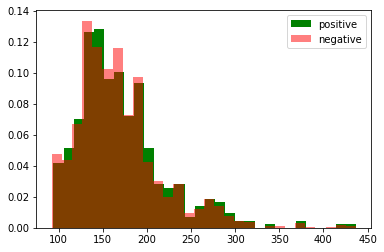

In [73]:
neg = fasta_to_df(temp_path + "/" + "extended_modified_non_coding.txt")
neg_length = neg['data'].apply(lambda x: len(x))
pos = fasta_to_df(temp_path.replace('negative', 'positive') + "/" + "extended_modified_non_coding.txt")
pos_length = pos['data'].apply(lambda x: len(x))

weights = np.ones_like(pos_length) / len(pos_length)
plt.hist(pos_length, weights=weights, bins=30,color='g', label="positive")

weights = np.ones_like(neg_length) / len(neg_length)
plt.hist(neg_length, weights=weights, bins=30,color='r', label="negative", alpha=0.5)

plt.legend()
plt.show()